# Molecular Tastants
Bogna Kilanowska 148252
https://www.kaggle.com/competitions/molecular-tastants

## Project setup
- load data
- load libs

In [208]:
import numpy as np 

np.random.seed(973)

In [209]:
import pandas as pd

df = pd.read_csv('data/train.csv')
df.head()

,molecule_id,smiles,taste
0,train_0,C=C1CC23CCC4C(C)(C(=O)O)CCCC4(C)C2CCC1(OC1OC(C...,6
1,train_1,Nc1ccccc1NS(=O)(=O)[O-].[Na+],3
2,train_2,O=C1NS(=O)(=O)c2cc(O)ccc21,6
3,train_3,OCC1OC(Oc2ccc3ccccc3c2)C(O)C(O)C1O,0
4,train_4,CCC1(C2=CCCCCC2)C(=O)NC(=O)NC1=O,0


## Preliminary data analysis

In [210]:
df.shape

(1809, 3)

In [211]:
print("Na count:")
print(df.isna().sum())
print("NULL count:")
print(df.isnull().sum())

Na count:
molecule_id    0
smiles         0
taste          0
dtype: int64
NULL count:
molecule_id    0
smiles         0
taste          0
dtype: int64


taste
0    731
6    589
3    149
7    125
2     69
8     63
1     50
5     25
4      8
Name: count, dtype: int64


array([[<Axes: title={'center': 'taste'}>]], dtype=object)

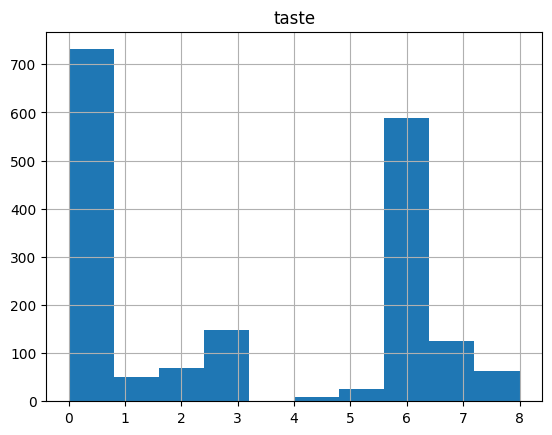

In [212]:
print(df.taste.value_counts())
df.hist(column='taste')

## Data pre-processing

### Data encoding

In [45]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem

def get_maccs_fps(dataframe):
    maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in dataframe['smiles']]
    maccs_lists = [list(l) for l in maccs]
    maccs_name = [f'MACCS_{i}' for i in range(167)]

    return pd.DataFrame(maccs_lists, index=dataframe.index, columns=maccs_name)

### Data balancing

In [94]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from collections import Counter

def balance_classes(X, y, info = True, sampling_strategy = 'auto', random_state = 973, k_neighbors = 5):
    sme = SMOTE(
        sampling_strategy=sampling_strategy,
        random_state = random_state,
        k_neighbors=k_neighbors)

    if info: print(f'Classes distribution before sampling : {sorted(Counter(y).items())}')
    X_resampled, y_resampled = sme.fit_resample(X, y)
    if info: print(f'Classes distribution after sampling: {sorted(Counter(y_resampled).items())}')

    return X_resampled, y_resampled

### Feature engineering

In [73]:
from sklearn.feature_selection import VarianceThreshold

def select_features(data, threshold = 0.05, info = True):
    
    if info: print(data.shape)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit_transform(data)
    if info: print(data[data.columns[selector.get_support(indices=True)]].shape)

    return data[data.columns[selector.get_support(indices=True)]]

## Train test split

In [213]:
from sklearn.model_selection import train_test_split

def train_test_split_data(X = df.smiles, y = df.taste, test_size=0.2, random_state=973):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f'Classes distribution train: {sorted(Counter(y_train).items())}')
    print(f'Classes distribution test: {sorted(Counter(y_test).items())}')

    return X_train, X_test, y_train, y_test 

In [214]:
X = get_maccs_fps(df)
y = df.taste

X_train, X_test, y_train, y_test = train_test_split_data(X, y, random_state=6)

Classes distribution train: [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution test: [(0, 137), (1, 8), (2, 16), (3, 35), (4, 2), (5, 4), (6, 126), (7, 18), (8, 16)]


## Model

In [215]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def train_model(X_train, y_train, 
                n_estimators=100, 
                max_features='sqrt', 
                max_depth=None,
                min_samples_split=2,
                bootstrap=True):

    clf = RandomForestClassifier(
        random_state=0,
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        bootstrap=bootstrap
        )
    
    clf.fit(X_train, y_train)
    
    return clf

def make_prediction(clf, X_test):
    y_pred = clf.predict(X_test)

    return y_pred

def evaluate_model(y_test, y_pred, print_acc = True, show_cm = True, cm_labels = [0,1,2,3,4,5,6,7,8]):
    acc = balanced_accuracy_score(y_test, y_pred)

    if print_acc:
        print(f"Balanced accuracy: {acc:.2%}")

    if show_cm:
        cm = confusion_matrix(y_test, y_pred, labels = cm_labels)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8])
        cm_display.plot()
        plt.show()

    return acc



## Evaluation

### Case 01: model

Balanced accuracy: 62.22%


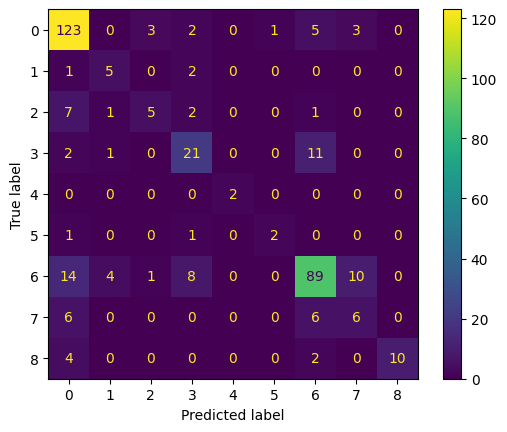

In [216]:
clf = train_model(X_train, y_train)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

In [217]:
n_iterations = 10
acc_scores = []

for i in range(n_iterations):
    clf = train_model(X_train, y_train)
    y_pred = make_prediction(clf, X_test)
    acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

    acc_scores.append(acc)

print(f'Min acc: {min(acc_scores):.2%}')
print(f'Max acc: {max(acc_scores):.2%}')
print(f'Avg acc: {sum(acc_scores)/n_iterations:.2%}')

Min acc: 62.22%
Max acc: 62.22%
Avg acc: 62.22%


### Case 02 balancing data + model

Classes distribution before sampling : [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution after sampling: [(0, 594), (1, 594), (2, 594), (3, 594), (4, 594), (5, 594), (6, 594), (7, 594), (8, 594)]
Balanced accuracy: 69.29%


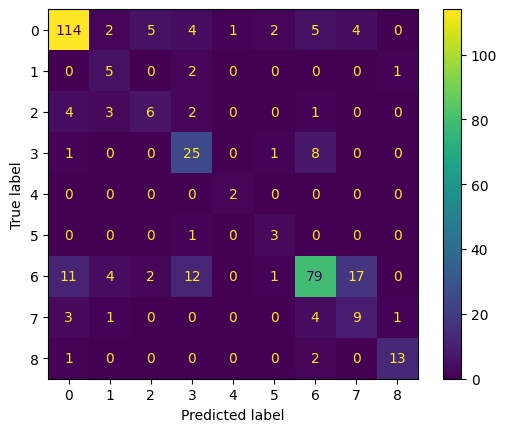

In [224]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=5)

clf = train_model(X_resampled, y_resampled)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)


Sampling strategy: minority
Min acc: 59.82%
Max acc: 62.66%
Avg acc: 61.26%

Sampling strategy: not minority
Min acc: 63.31%
Max acc: 67.99%
Avg acc: 66.28%

Sampling strategy: not majority
Min acc: 64.36%
Max acc: 69.29%
Avg acc: 67.48%

Sampling strategy: all
Min acc: 64.36%
Max acc: 69.29%
Avg acc: 67.48%


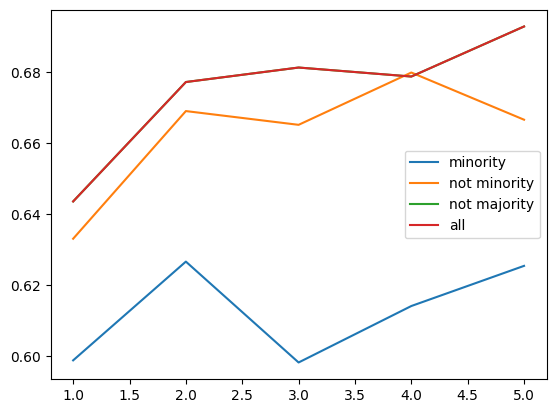

In [219]:
n_iterations = 10


sampling_strategy = ['minority', 'not minority', 'not majority', 'all']
k_neighbors = np.arange(1, 6, 1)

for s in sampling_strategy:
    
    acc_scores = []
    for k in k_neighbors:
        X_resampled, y_resampled = balance_classes(X_train, y_train, info = False, sampling_strategy=s, k_neighbors=k)

        clf = train_model(X_resampled, y_resampled)
        y_pred = make_prediction(clf, X_test)
        acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

        acc_scores.append(acc)

    print(f'\nSampling strategy: {s}')
    print(f'Min acc: {min(acc_scores):.2%}')
    print(f'Max acc: {max(acc_scores):.2%}')
    print(f'Avg acc: {sum(acc_scores)/k_neighbors.size:.2%}')

    plt.plot(k_neighbors, acc_scores, label = s)

plt.legend()
plt.show() 
    

### Case 03: feature engineering + model

(1447, 167)
(1447, 140)
Balanced accuracy: 64.26%


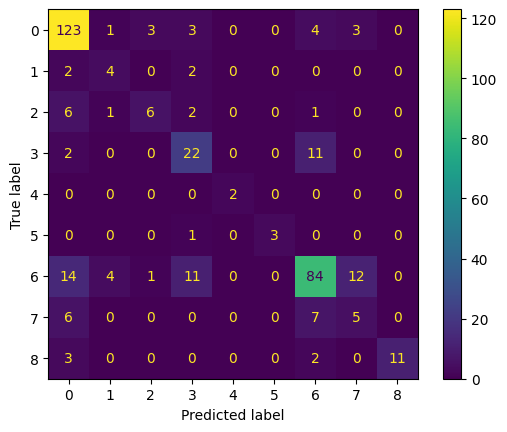

In [220]:
X_selected = select_features(pd.DataFrame(X_train), threshold = 0.01)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_train)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

Min acc: 47.58%
Max acc: 64.26%
Avg acc: 57.95%


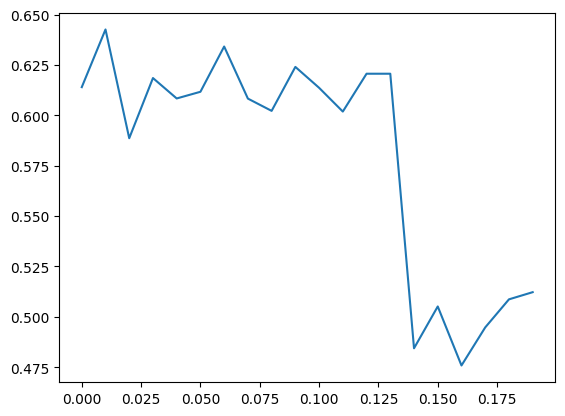

In [221]:
acc_scores = []
thresholds = np.arange(0, 0.2, 0.01)

for t in thresholds:
    X_selected = select_features(pd.DataFrame(X_train), threshold = t, info = False)
    column_names = X_selected.columns
    X_selected_test = X_test[column_names]

    clf = train_model(X_selected, y_train)
    y_pred = make_prediction(clf, X_selected_test)
    acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

    acc_scores.append(acc)

print(f'Min acc: {min(acc_scores):.2%}')
print(f'Max acc: {max(acc_scores):.2%}')
print(f'Avg acc: {sum(acc_scores)/thresholds.size:.2%}')

plt.plot(thresholds, acc_scores)
plt.show() 

### Case 04: balancing data + feature engineering + model

Classes distribution before sampling : [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution after sampling: [(0, 594), (1, 594), (2, 594), (3, 594), (4, 594), (5, 594), (6, 594), (7, 594), (8, 594)]
(5346, 167)
(5346, 130)
Balanced accuracy: 69.91%


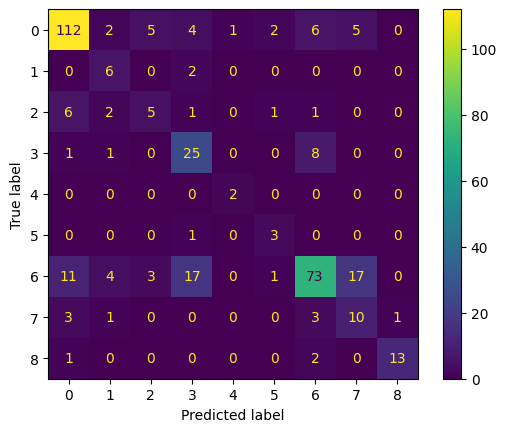

In [222]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.02)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_resampled)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)


Threshold: 0.0
Min acc: 64.43%
Max acc: 68.09%
Avg acc: 66.32%

Threshold: 0.01
Min acc: 64.45%
Max acc: 68.37%
Avg acc: 66.79%

Threshold: 0.02
Min acc: 61.96%
Max acc: 69.91%
Avg acc: 66.56%

Threshold: 0.03
Min acc: 63.98%
Max acc: 69.16%
Avg acc: 67.10%

Threshold: 0.04
Min acc: 63.04%
Max acc: 68.31%
Avg acc: 66.90%

Threshold: 0.05
Min acc: 63.68%
Max acc: 68.72%
Avg acc: 67.22%

Threshold: 0.06
Min acc: 62.83%
Max acc: 67.82%
Avg acc: 66.38%

Threshold: 0.07
Min acc: 55.53%
Max acc: 68.80%
Avg acc: 64.21%

Threshold: 0.08
Min acc: 64.73%
Max acc: 69.47%
Avg acc: 67.22%

Threshold: 0.09
Min acc: 65.14%
Max acc: 69.15%
Avg acc: 67.12%

Threshold: 0.1
Min acc: 56.80%
Max acc: 67.82%
Avg acc: 65.13%

Threshold: 0.11
Min acc: 53.01%
Max acc: 68.93%
Avg acc: 62.84%

Threshold: 0.12
Min acc: 53.73%
Max acc: 70.79%
Avg acc: 63.96%

Threshold: 0.13
Min acc: 53.73%
Max acc: 70.06%
Avg acc: 63.54%

Threshold: 0.14
Min acc: 53.31%
Max acc: 68.03%
Avg acc: 61.79%

Threshold: 0.15
Min acc: 5

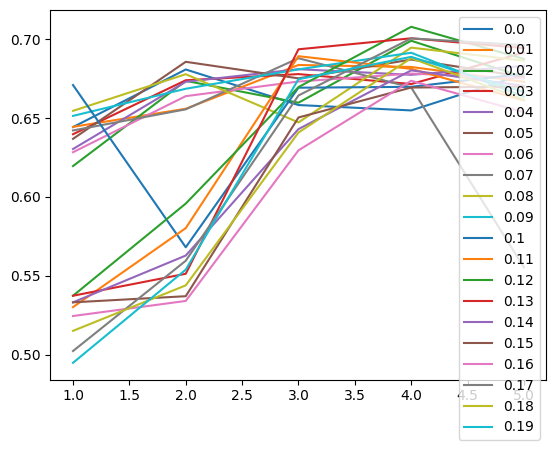

In [223]:
acc_scores = []

sampling_strategy = ['minority', 'not minority', 'not majority', 'all']
k_neighbors = np.arange(1, 6, 1)
thresholds = np.arange(0, 0.2, 0.01)

for t in thresholds:
    acc_scores = []
    for k in k_neighbors:
        X_resampled, y_resampled = balance_classes(X_train, y_train, info = False, sampling_strategy='not majority', k_neighbors=k)

        X_selected = select_features(pd.DataFrame(X_resampled), threshold = t, info = False)
        column_names = X_selected.columns
        X_selected_test = X_test[column_names]

        clf = train_model(X_selected, y_resampled)
        y_pred = make_prediction(clf, X_selected_test)
        acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

        acc_scores.append(acc)

    print(f'\nThreshold: {t}')
    print(f'Min acc: {min(acc_scores):.2%}')
    print(f'Max acc: {max(acc_scores):.2%}')
    print(f'Avg acc: {sum(acc_scores)/k_neighbors.size:.2%}')

    plt.plot(k_neighbors, acc_scores, label = t)

plt.legend()
plt.show() 

## Hyperparameter tuning

In [225]:
from sklearn.model_selection import GridSearchCV

X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.02)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

parameters = {
    'n_estimators':(50, 100, 300),
    'max_features':('log2', 'sqrt'),
    'max_depth': (None,100,300,500,700),
    'min_samples_split': (2,3,4,5,6,7,8),
    'bootstrap': [True, False]
    }

grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=parameters,
                           verbose=2) 

grid_search.fit(X_selected, y_resampled)

        # n_estimators=300,
        # max_features='log2',
        # max_depth=100,
        # min_samples_split=7,
        # bootstrap=False

Classes distribution before sampling : [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution after sampling: [(0, 594), (1, 594), (2, 594), (3, 594), (4, 594), (5, 594), (6, 594), (7, 594), (8, 594)]
(5346, 167)
(5346, 130)
Fitting 5 folds for each of 420 candidates, totalling 2100 fits
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_spl

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': (None, 100, 300, 500, 700),
                         'max_features': ('log2', 'sqrt'),
                         'min_samples_split': (2, 3, 4, 5, 6, 7, 8),
                         'n_estimators': (50, 100, 300)},
             verbose=2)

In [226]:
pd.DataFrame(grid_search.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
263,2.559117,0.061379,0.125813,0.001552,False,100,log2,5,300,"{'bootstrap': False, 'max_depth': 100, 'max_fe...",0.853271,0.930776,0.927970,0.929841,0.936389,0.915650,0.031315,1
364,0.991145,0.072319,0.039807,0.002173,False,500,sqrt,4,100,"{'bootstrap': False, 'max_depth': 500, 'max_fe...",0.855140,0.930776,0.926099,0.926099,0.935454,0.914714,0.029988,2
257,2.796991,0.095579,0.128035,0.001763,False,100,log2,3,300,"{'bootstrap': False, 'max_depth': 100, 'max_fe...",0.849533,0.931712,0.928906,0.928906,0.933583,0.914528,0.032546,3
367,0.979055,0.029720,0.041860,0.002828,False,500,sqrt,5,100,"{'bootstrap': False, 'max_depth': 500, 'max_fe...",0.855140,0.930776,0.922357,0.924228,0.938260,0.914152,0.030029,4
410,3.117769,0.369529,0.147817,0.039449,False,700,sqrt,5,300,"{'bootstrap': False, 'max_depth': 700, 'max_fe...",0.853271,0.929841,0.927035,0.924228,0.935454,0.913966,0.030574,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.334643,0.008455,0.022855,0.000721,True,500,log2,8,50,"{'bootstrap': True, 'max_depth': 500, 'max_fea...",0.844860,0.913003,0.908326,0.906455,0.919551,0.898439,0.027168,416
36,0.392763,0.005196,0.023375,0.000824,True,None,sqrt,7,50,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.841121,0.910196,0.912067,0.906455,0.920486,0.898065,0.028841,417
123,0.385415,0.008190,0.024956,0.004604,True,300,sqrt,8,50,"{'bootstrap': True, 'max_depth': 300, 'max_fea...",0.842056,0.910196,0.911132,0.907390,0.919551,0.898065,0.028297,418
39,0.382462,0.006289,0.022727,0.000571,True,None,sqrt,8,50,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.841121,0.914874,0.907390,0.909261,0.916745,0.897878,0.028587,419


In [227]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=100, max_features='log2',
                       min_samples_split=5, n_estimators=300)

## Looking for better train test split for training


Threshold: 0.0
Min acc: 54.03%
Max acc: 56.27%
Avg acc: 55.02%

Threshold: 0.01
Min acc: 52.07%
Max acc: 55.54%
Avg acc: 53.79%

Threshold: 0.02
Min acc: 53.23%
Max acc: 54.98%
Avg acc: 54.17%

Threshold: 0.03
Min acc: 51.44%
Max acc: 54.59%
Avg acc: 53.35%

Threshold: 0.04
Min acc: 53.70%
Max acc: 55.43%
Avg acc: 54.53%

Threshold: 0.05
Min acc: 53.27%
Max acc: 55.58%
Avg acc: 54.30%

Threshold: 0.06
Min acc: 51.17%
Max acc: 61.58%
Avg acc: 54.62%

Threshold: 0.07
Min acc: 53.22%
Max acc: 59.12%
Avg acc: 55.29%

Threshold: 0.08
Min acc: 54.14%
Max acc: 55.55%
Avg acc: 54.96%

Threshold: 0.09
Min acc: 52.28%
Max acc: 54.89%
Avg acc: 53.60%

Threshold: 0.1
Min acc: 51.33%
Max acc: 55.87%
Avg acc: 52.78%

Threshold: 0.11
Min acc: 51.39%
Max acc: 54.52%
Avg acc: 52.94%

Threshold: 0.12
Min acc: 50.30%
Max acc: 54.54%
Avg acc: 52.48%

Threshold: 0.13
Min acc: 50.39%
Max acc: 57.59%
Avg acc: 53.79%

Threshold: 0.14
Min acc: 50.26%
Max acc: 55.33%
Avg acc: 52.71%

Threshold: 0.15
Min acc: 5

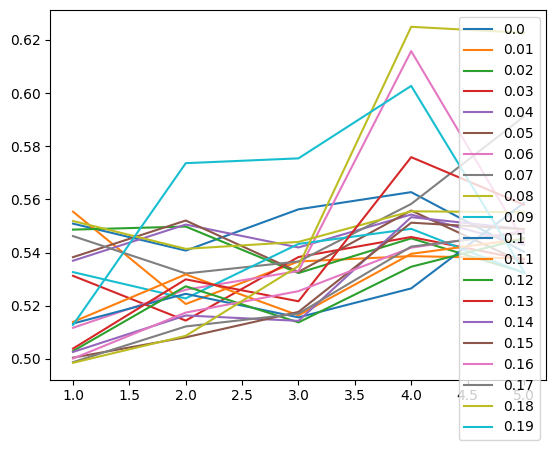

In [205]:
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split_data(X, y, random_state=i)

    try:
        X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)
    except ValueError:
        continue

    X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.02, info = False)
    column_names = X_selected.columns
    X_selected_test = X_test[column_names]

    print(f'\n{i}')
    clf = train_model(X_selected, y_resampled)
    y_pred = make_prediction(clf, X_selected_test)
    acc = evaluate_model(y_test, y_pred, show_cm=False)

## Model training

Classes distribution before sampling : [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution after sampling: [(0, 594), (1, 594), (2, 594), (3, 594), (4, 594), (5, 594), (6, 594), (7, 594), (8, 594)]
(5346, 167)
(5346, 130)
Balanced accuracy: 66.22%


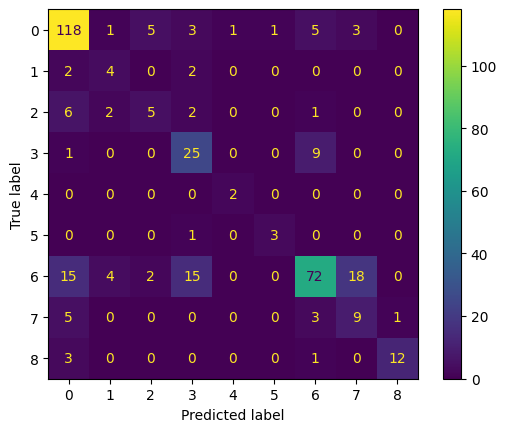

In [228]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.02)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_resampled,
                  bootstrap=False, max_depth=100, max_features='log2',
                       min_samples_split=5, n_estimators=300)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

## Pipeline draft

Classes distribution : [(0, 731), (1, 50), (2, 69), (3, 149), (4, 8), (5, 25), (6, 589), (7, 125), (8, 63)]
Classes distribution : [(0, 731), (1, 731), (2, 731), (3, 731), (4, 731), (5, 731), (6, 731), (7, 731), (8, 731)]
(6579, 167)
(6579, 114)
Classes distribution train: [(0, 598), (1, 582), (2, 586), (3, 560), (4, 577), (5, 591), (6, 604), (7, 583), (8, 582)]
Classes distribution test: [(0, 133), (1, 149), (2, 145), (3, 171), (4, 154), (5, 140), (6, 127), (7, 148), (8, 149)]
Balanced accuracy: 89.39%


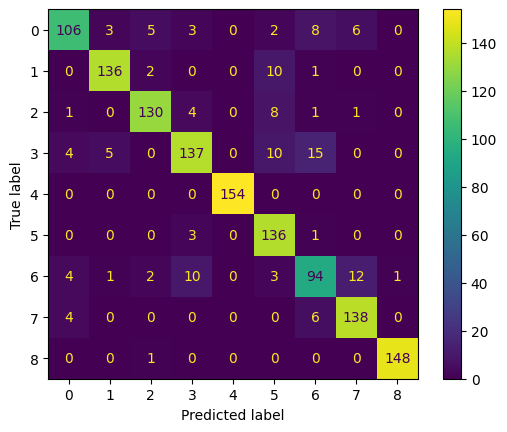

In [57]:
# 1) Zmień encoding
# ecfp_fp = ECFPFingerprint() #zmień rozmiar fingerprinta MACCS
# X = ecfp_fp.transform(df.smiles)
# y = df.taste
X = get_maccs_fps(df)
y = df.taste

# 2) Zbalansuj klasy
X_resampled, y_resampled = balance_classes(X, y)

# 3) Wyselekcjonuj atrybuty
X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.05)
column_names = X_selected.columns

# 4) Train test split
X_train, X_test, y_train, y_test  = train_test_split_data(X_selected, y_resampled)

# 5) Train model
clf = train_model(X_train, y_train)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

## Making predictions

In [229]:
df = pd.read_csv('data/test.csv')
df.head()

,molecule_id,smiles
0,test_0,NC(=O)NN=Cc1ccc([N+](=O)[O-])o1
1,test_1,CCOC=O
2,test_2,CCOC(=O)C(Cc1c[nH]c2ccccc12)NC(=O)C1CCCN1C(=O)...
3,test_3,CC1=CCC(C(C)(C)OC(=O)c2ccccc2N)CC1
4,test_4,O=S(=O)([O-])Nc1nnc(-c2ccccc2Br)s1.[Na+]


In [230]:
# 1) Zmień encoding
# ecfp_fp = ECFPFingerprint() #zmień rozmiar fingerprinta MACCS
# X = ecfp_fp.transform(df.smiles)
# y = df.taste
maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in df['smiles']]
maccs_lists = [list(l) for l in maccs]
maccs_name = [f'MACCS_{i}' for i in range(167)]
X = pd.DataFrame(maccs_lists, index=df.index, columns=maccs_name)

# 3) Wyselekcjonuj atrybuty
X = X[column_names]

# 4) Predict
model_predictions = clf.predict(X)

# 5) Save results


In [231]:
import csv
csv_file_path = f'./results/results_model_hyp_4_02_6.csv'

with open(csv_file_path, mode='w', newline='') as file:
    
    writer = csv.writer(file)
    file.write('molecule_id' + ',' + 'taste' + '\n')
    
    for i, pred in enumerate(model_predictions):
        file.write('test_' + str(i) + ',' + str(pred) + '\n')

print(f"CSV file '{csv_file_path}' created successfully!!!")

CSV file './results/results_model_hyp_4_02_6.csv' created successfully!!!
